In [1]:
# EXTRACT TILES


import slideflow as sf
import torch
import timm
import os

from slideflow.model.extractors._factory_torch import TorchFeatureExtractor
from slideflow.slide import qc


# if not os.path.exists('data/tiles'):
wsi = sf.WSI('data/med_sample1.tiff', tile_px=224, tile_um='20x')
wsi.qc('both')
wsi.extract_tiles(
    tfrecord_dir='data/tiles', 
    # whitespace_fraction=1.0, 
    grayspace_fraction=1.0,
    # grayspace_threshold=0.01, 
    normalizer='reinhard',
    shuffle=False
)
tfr = sf.TFRecord('data/tiles/med_sample1.tfrecords')

/home/jakub/miniconda3/envs/CPATH/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[14:45:18] INFO     No ROI for med_sample1, using whole slide.

[14:45:20] INFO     Finished tile extraction for med_sample1 (713 tiles of 713 possible)

In [2]:
# EXTRACT FEATURES


class UNI2FeatureExtractor(TorchFeatureExtractor):
    tag = 'uni2'  # Unique identifier for registration
    
    def __init__(self, device='cuda'):
        super().__init__()
        timm_kwargs = {
            'img_size': 224, 
            'patch_size': 14, 
            'depth': 24,
            'num_heads': 24,
            'init_values': 1e-5, 
            'embed_dim': 1536,
            'mlp_ratio': 2.66667*2,
            'num_classes': 0, 
            'no_embed_class': True,
            'mlp_layer': timm.layers.SwiGLUPacked, 
            'act_layer': torch.nn.SiLU, 
            'reg_tokens': 8, 
            'dynamic_img_size': True
        }
        # self.model = timm.create_model("hf_hub:prov-gigapath/prov-gigapath", pretrained=True)
        self.model = timm.create_model("hf-hub:MahmoodLab/UNI2-h", pretrained=True, **timm_kwargs)
        self.model = self.model.to(device)
        self.model.eval()
        self.num_features = 1536
        
        self.transform = self.build_transform(img_size=224, resize=224)
        self.preprocess_kwargs = {'standardize': False}

    def dump_config(self):
        return self._dump_config(
            class_name='UNI2FeatureExtractor'
        )


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
patch_size = 224
batch_size = 16
model = UNI2FeatureExtractor(device=device)
n = len(tfr) + 1

locx = torch.zeros(n, dtype=torch.int32)
locy = torch.zeros(n, dtype=torch.int32)
features = torch.zeros(n, model.num_features, dtype=torch.float32)
images = torch.zeros(n, patch_size, patch_size, 3, dtype=torch.uint8)
batch = []
maxx = 0
maxy = 0

print(f"Num patches: {n}, Image size: {maxx, maxy}, Patch size: {patch_size}, Batch size: {batch_size}")

for i, record in enumerate(tfr, start=1):
    image = sf.io.decode_image(bytes(record['image_raw'])).to(device)
    locx[i - 1] = record['loc_x'] // (2 * patch_size)
    locy[i - 1] = record['loc_y'] // (2 * patch_size)
    
    maxx = max(maxx, (locx[i - 1] + 1) * patch_size)
    maxy = max(maxy, (locy[i - 1] + 1) * patch_size)
    
    images[i - 1] = image
    # batch.append(image)

    if i % batch_size == 0:
        img_batch = images[i - batch_size:i]
        batch = []
        with torch.no_grad():
            f = model(img_batch)
        features[i - batch_size:i] = f

Num patches: 714, Image size: (0, 0), Patch size: 224, Batch size: 16


In [6]:
# CLUSTERING
from sklearn.cluster import HDBSCAN
# from kmeans_pytorch import kmeans


num_clusters = 8
algo = HDBSCAN()
algo.fit(features.cpu().numpy())
cluster_ids = algo.labels_

# cluster_ids, cluster_centers = kmeans(
#     X=features, 
#     num_clusters=num_clusters, 
#     distance='euclidean', 
#     device=features.device
# )

tensor(7840, dtype=torch.int32) tensor(10080, dtype=torch.int32)


100%|██████████| 714/714 [00:00<00:00, 2035.57it/s]


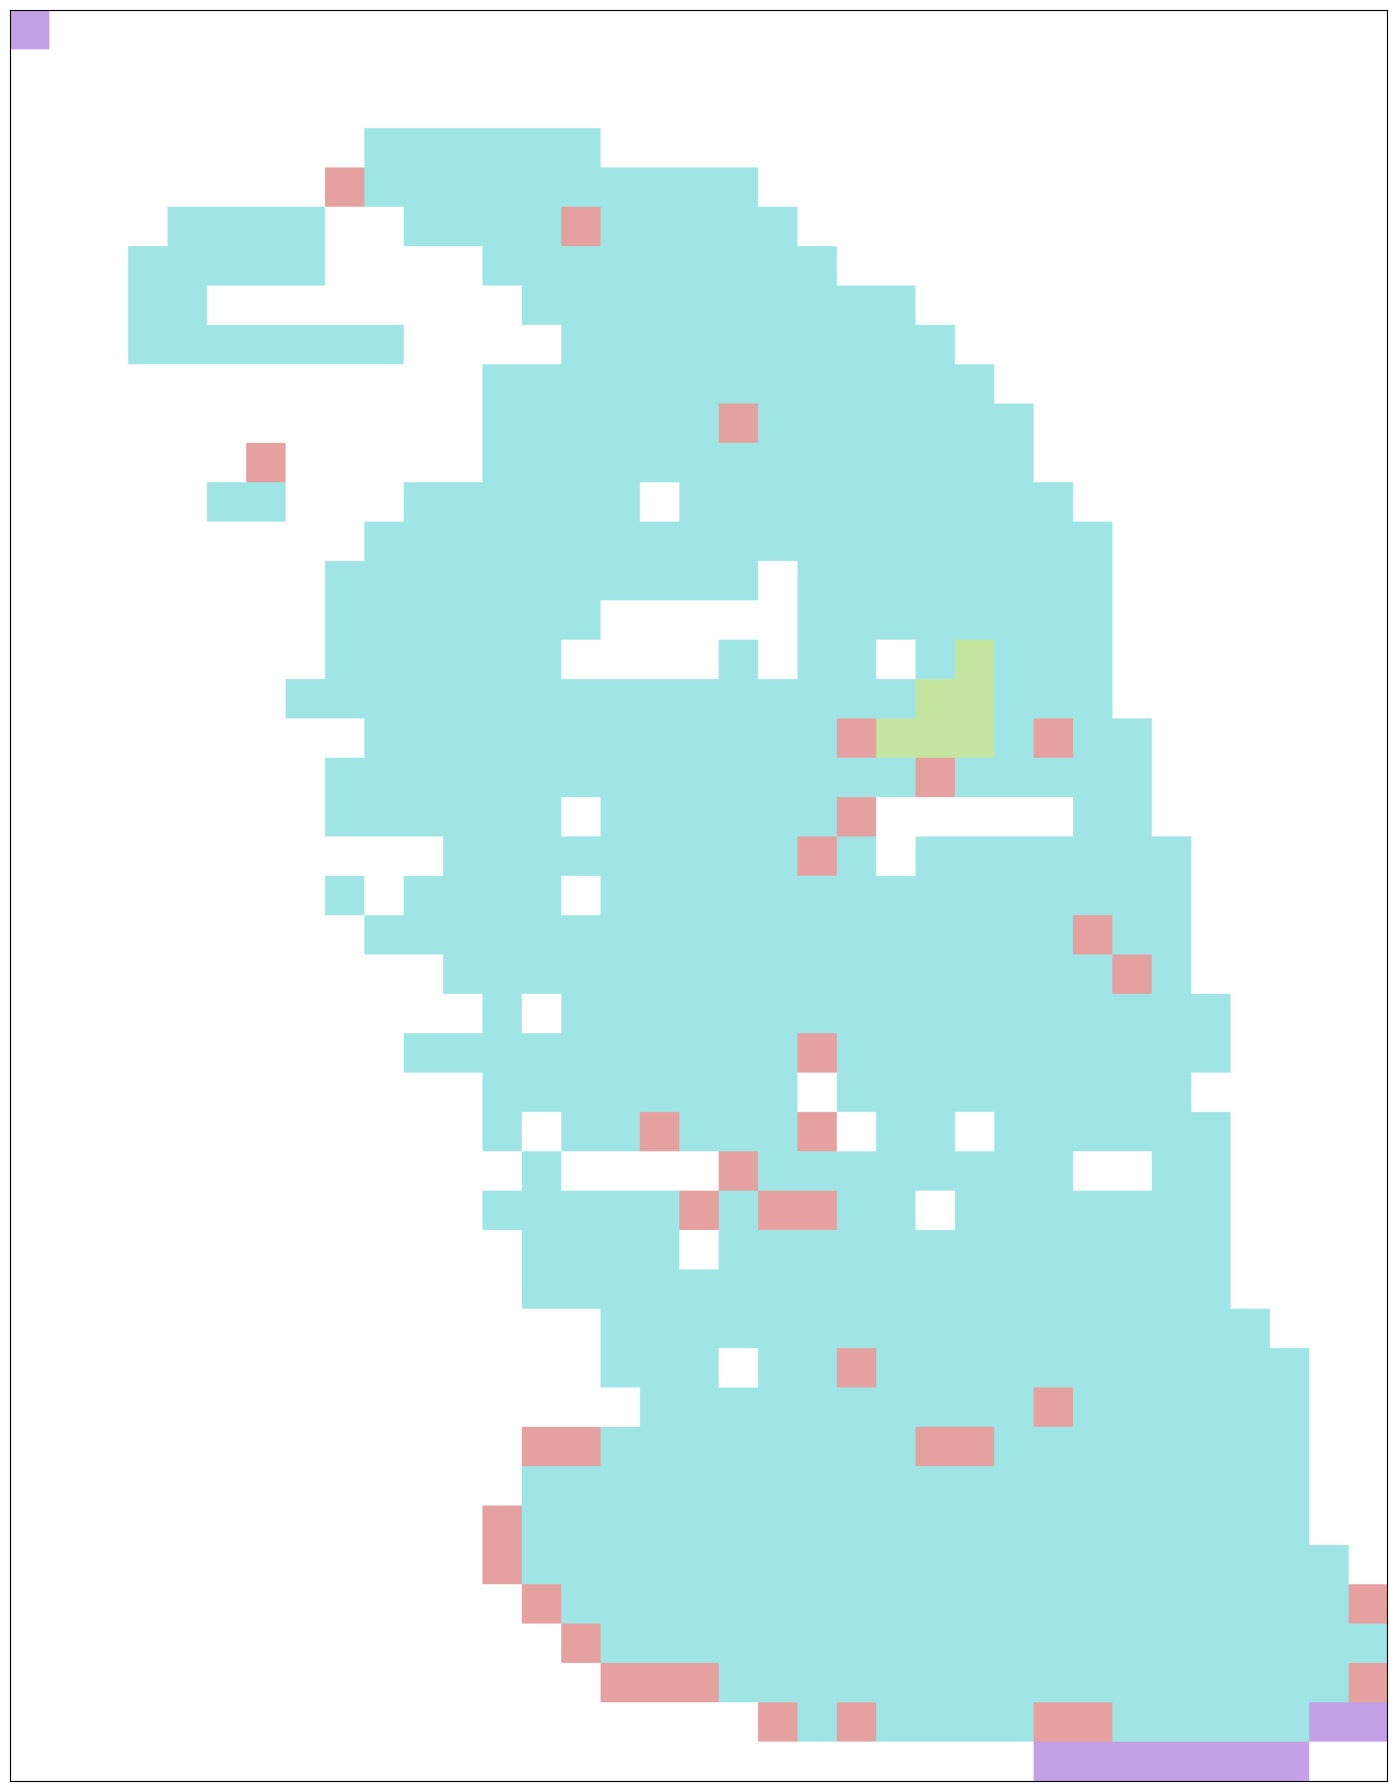

In [9]:
# VISUALIZE CLUSTERS

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm


np.random.seed(12)

def generate_tints(clusters):
    # clusters = clusters_tensor.numpy()  # Convert to NumPy if using Torch
    unique_clusters = np.unique(clusters)
    n = len(unique_clusters)
    hues = np.linspace(0, 1, n, endpoint=False)  # Evenly spaced hues
    saturation = 0.3  # High saturation for vivid colors
    value = 0.9  # High brightness
    
    tint_map = {}
    for i, cluster in enumerate(unique_clusters):
        # Convert HSV to RGB
        h = hues[i] * 6
        c = value * saturation
        x = c * (1 - abs(h % 2 - 1))
        m = value - c
        
        if h < 1: r, g, b = c, x, 0
        elif h < 2: r, g, b = x, c, 0
        elif h < 3: r, g, b = 0, c, x
        elif h < 4: r, g, b = 0, x, c
        elif h < 5: r, g, b = x, 0, c
        else: r, g, b = c, 0, x
        
        tint_map[int(cluster)] = [r + m, g + m, b + m]
    
    return tint_map

def apply_tint(image_array, tint):
    image_array = np.ones((image_array.shape), dtype=np.float32)
    return np.clip(image_array * tint, 0, 1)


print(maxx, maxy)
final_image = np.ones((maxy, maxx, 3), dtype=np.float32)
tint_map = generate_tints(cluster_ids)
columns = maxx // patch_size + 1
rows = maxy // patch_size + 1

plt.figure(figsize=(columns // 2, rows // 2), frameon=False)
plt.xticks([])
plt.yticks([])
mxx = 0
for i in tqdm(range(n)):
    patchx = locx[i].item()
    patchy = locy[i].item()
    
    # print(patchx // (2 * patch_size), patchy // (2 * patch_size))
    # for j in range(num_subpatches):
    #     # subpatch = images[i, j] / 255.0

    #     sx = (patchx * patch_size) + (j % (patch_size // subpatch_size)) * subpatch_size
    #     sy = (patchy * patch_size) + (j // (patch_size // subpatch_size)) * subpatch_size

    cluster_id = cluster_ids[i].item()
    tint = tint_map[cluster_id]
    patch = apply_tint(images[i].numpy() / 255.0, tint)
    final_image[patchy * patch_size:(patchy + 1)* patch_size, patchx * patch_size:(patchx + 1) * patch_size] = patch
    mxx = max(mxx, patchx * patch_size + patch_size)

plt.imshow(final_image)
# plt.subplots_adjust(wspace=0, hspace=0)